In [7]:
!pip install pandas numpy matplotlib seaborn scikit-learn graphviz


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from prepare_training_data import  train_all_models
# from decision_tree_model import train_and_visualize_trees, evaluate_models
from visualize import visualize_all
from visualize import analyze_accuracy_vs_depth
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

In [9]:
dataset_path = "Data/penguinsData.csv"

In [10]:

df = pd.read_csv(dataset_path)



# Define the column to be excluded
exclude_column = 'Comments'

# Fill missing numerical columns with the mean of each column
df = df.apply(lambda col: col.fillna(col.mean()) if col.dtype in ['float64', 'int64'] and col.name != exclude_column else col)

# Fill missing categorical columns with the most frequent value (mode), excluding the specified column
df = df.apply(lambda col: col.fillna(col.mode()[0]) if col.dtype == 'object' and col.name != exclude_column else col)

print(df)



    studyName  Sample Number                                    Species  \
0     PAL0910            103          Gentoo penguin (Pygoscelis papua)   
1     PAL0708              9        Adelie Penguin (Pygoscelis adeliae)   
2     PAL0910             62  Chinstrap penguin (Pygoscelis antarctica)   
3     PAL0708             23        Adelie Penguin (Pygoscelis adeliae)   
4     PAL0708             25  Chinstrap penguin (Pygoscelis antarctica)   
..        ...            ...                                        ...   
339   PAL0708             11          Gentoo penguin (Pygoscelis papua)   
340   PAL0708              8        Adelie Penguin (Pygoscelis adeliae)   
341   PAL0809             64        Adelie Penguin (Pygoscelis adeliae)   
342   PAL0910            150        Adelie Penguin (Pygoscelis adeliae)   
343   PAL0910            123          Gentoo penguin (Pygoscelis papua)   

     Region     Island               Stage Individual ID Clutch Completion  \
0    Anvers     Bisco

In [11]:
# Initialization
label_encoder = LabelEncoder()
hp_df = df
# X: columns that are not target
    # "target": Determine target
    # axis=1: 1 if we want to remove column(target), 0 if we want to remove row
X = hp_df.drop("Species", axis=1)
# y: column that is target
y = hp_df["Species"]

In [12]:
def prepare_splits(feature, target, splits=[(0.4, 0.6), (0.6, 0.4), (0.8, 0.2), (0.9, 0.1)]):
    """
    Prepares the data by applying one-hot encoding and splitting into train/test sets.

    Arguments:
    - feature: Feature set (DataFrame)
    - target: Target labels (Series or array)
    - splits: Proportions for train/test split (default: 40/60, 60/40, 80/20, 90/10)

    Returns:
    - datasets: List of tuples containing the training and testing data (features and labels)
    """

    # One-hot encode categorical features
    feature_encoded = pd.get_dummies(feature, drop_first=True)
    feature_names = feature_encoded.columns.tolist()
    
    # Initialize list to hold datasets for each split
    datasets = []

    # Split the data based on the proportions defined in 'splits'
    for train_size, test_size in splits:
        feature_train, feature_test, label_train, label_test = train_test_split(
            feature_encoded,
            target,
            train_size=train_size,
            test_size=test_size,
            stratify=target,
            shuffle=True,
            random_state=42
        )
        datasets.append((feature_train, feature_test, label_train, label_test))

    return datasets, feature_names


In [13]:

def evaluate_model(clf, feature_test, label_test, class_names, title=""):
    """
    Arguments:
    - clf: Trained decision tree model.
    - feature_test: Features used to test the model (excluding target).
    - label_test: Actual target labels to compare predictions against.
    - class_names: List of class names for the target variable.
    - title: Title for the confusion matrix plot.
    """
    
    # Shortened class names (modify this as per your classes)
    short_class_names = ["Adelie Penguin",
                    
                    "Chinstrap penguin","Gentoo penguin"]  # Example: Modify according to your labels
    
    # Use the model to predict labels
    label_pred = clf.predict(feature_test)
    
    # Generate classification report with shortened class names
    print(classification_report(label_test, label_pred, target_names=short_class_names))
    
    # Generate confusion matrix
    cm = confusion_matrix(label_test, label_pred)
    
    # Display confusion matrix with shortened labels
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=short_class_names)
    
    # Set the color for the confusion matrix
    disp.plot(cmap=plt.cm.Blues)
    
    # Set the title for the confusion matrix
    plt.title(f"Confusion Matrix {title}")
    
    # Remove grid
    plt.grid(False)
    
    # Show the chart
    plt.show()


In [14]:
def evaluate_all(clfs, datasets, class_names):
    # 2.3 Evaluating the decision tree classifiers
    
    #Argument:
        # + clf: list of models of decision tree
        # feature_names: list of feature names
        # class_names: Disease or No disease
    for i, (clf, (feature_train, feature_test, label_train, label_test)) in enumerate(zip(clfs, datasets)):
        # recalculate % train
        percent_train = len(feature_train) * 100 / (len(feature_train) + len(feature_test))
        depth = clf.get_depth()
        # print the title
        print(f"📊 Evaluation Tree {i+1}: ({percent_train:.1f}% train)")
        # call the evaluate_model to draw confusion_matrix
        evaluate_model(clf, feature_test, label_test, class_names, title=f"(Depth = {depth},Split {i+1})")


In [15]:


def plot_original_distribution(target, title="Original Dataset"):
    """
    Plots the distribution of the original dataset target labels and displays the actual counts on top of each bar.

    Arguments:
    - target: The target column containing the class labels (e.g., "Disease", "No disease").
    - title: The title for the plot (default is "Original Dataset").
    """
    
    # Shortened labels (adjust based on your actual class labels)
    short_labels = ["Gentoo penguin", 
                    "Adelie Penguin",
                    "Chinstrap penguin",]   # Modify this list as needed
    
    # Draw the countplot for the original target distribution
    ax = sns.countplot(x=target)
    
    # Set the title, axis labels
    plt.title(title)  # Set title
    plt.xlabel("Label")  # Set x-axis label
    plt.ylabel("Count")  # Set y-axis label
    
    # Shorten x-axis labels
    ax.set_xticklabels(short_labels, rotation=0)  # Ensure labels are horizontal and shortened
    
    # Add actual number on top of the bars
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{int(height)}', 
                    (p.get_x() + p.get_width() / 2., height),  # Position the text at the top of each bar
                    ha='center', va='center', fontsize=12, color='black', 
                    xytext=(0, 9), textcoords='offset points')  # Adjust text position slightly upwards
    
    # Set grid for better readability
    plt.grid(True, linestyle="--", alpha=0.5)
    
    # Show the plot
    plt.show()


In [16]:
def plot_class_distributions(datasets, splits, title):
    #Argument:
        # + datasets: For data after we split
        # + slipts: the proportions
        # + title: Name of the this data 
    
    # Draw the chart for test and train
    
    # For each pair of datasets: 
    
    short_labels = {
    "Adelie Penguin (Pygoscelis adeliae)": "Adelie",
    "Chinstrap penguin (Pygoscelis antarctica)": "Chinstrap",
    "Gentoo penguin (Pygoscelis papua)": "Gentoo"
    }
    
    order = ["Adelie", "Chinstrap", "Gentoo"]
    
    for i, (__, __, label_train, label_test) in enumerate(datasets):
        
        # Create the figure with 2 charts in 1 row (train vs. test)
        fig, axs = plt.subplots(1, 2, figsize=(10, 4))
        
        # axs[0] mean the first chart (train)
        # x for the x axis. It takes lables from label_train (like 0,1)
        sns.countplot(x=label_train, ax=axs[0], order=order)
        # Set the name for the first chart
        axs[0].set_title(f"Train {int(splits[i][0]*100)}%")  
        
        # axs[1] mean the second chart (test)
        # It takes lables from y_tes
        sns.countplot(x=label_test, ax=axs[1], order=order) 
        
        # Set the name for the second chart
        axs[1].set_title(f"Test {int(splits[i][1]*100)}%")
        
        for ax in axs:
            
            ax.set_xlabel("Target") # x axis presents Tagert (0,1)
            ax.set_ylabel("Count") # y axis presents Quantity 
            
            # True: show the grid to read easily
            # line: grid draw by "--"
            # alpha: opacity of the grid 
            ax.grid(True, linestyle="--", alpha=0.5)
            for p in ax.patches:
                height = p.get_height()
                ax.annotate(f'{int(height)}', 
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', 
                fontsize=12, color='black', 
                xytext=(0, 9), textcoords='offset points') 
        
        # Set general chart properties
        for ax in axs:
            ax.set_xlabel("Target")  # x-axis represents the target (0, 1)
            ax.set_ylabel("Count")   # y-axis represents the count of samples
            ax.grid(True, linestyle="--", alpha=0.5)  # Add a grid for readability
            ax.yaxis.set_major_locator(MaxNLocator(integer=True))  # Ensure integer values on y-axis
        
        # Add a global title for both plots
        plt.suptitle(title + f" {int(splits[i][0]*100)}/{int(splits[i][1]*100)}")
        
        # Adjust layout to make room for the global title
        plt.tight_layout()
        plt.show()

C:\Users\ACER\AppData\Local\Temp\ipykernel_6368\2332379247.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(short_labels, rotation=0)  # Ensure labels are horizontal and shortened


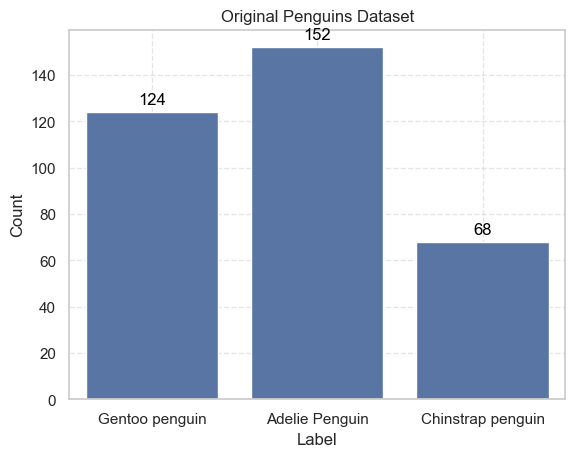

In [17]:
def plot_original_distribution(target, title="Original Dataset"):
    # Draw the chart of the original data 

    short_labels = {
    "Adelie Penguin (Pygoscelis adeliae)": "Adelie",
    "Chinstrap penguin (Pygoscelis antarctica)": "Chinstrap",
    "Gentoo penguin (Pygoscelis papua)": "Gentoo"
    }

    target = target.map(short_labels)

    order = ["Adelie", "Chinstrap", "Gentoo"]
    
    ax = sns.countplot(x=target, order=order)
    for p in ax.patches:
        height = p.get_height() 
        ax.annotate(f'{int(height)}', 
        (p.get_x() + p.get_width() / 2., height),  
        ha='center', va='center',  
        fontsize=12, color='black', 
        xytext=(0, 9), textcoords='offset points')
    plt.title(title) # set title
    plt.xlabel("Label") # set x axis title
    plt.ylabel("Count") # set y axis title
    plt.grid(True, linestyle="--", alpha=0.5) # Same
    plt.show()

In [18]:
# set up the proportions
splits = [(0.4, 0.6), (0.6, 0.4), (0.8, 0.2), (0.9, 0.1)]
# Implement preparing data 
datasets = prepare_splits(X, y, splits)

NameError: name 'train_test_split' is not defined

In [ ]:
def plot_accuracy_vs_depth(results, title="Accuracy vs. Tree Depth"):
    
    df = results.copy()

    mask_none = df["max_depth"] == "None"
    df_numeric = df[~mask_none]
    df_none    = df[ mask_none]
    
   
    df_ordered = pd.concat([df_numeric, df_none], ignore_index=True)
    
   
    df_ordered["x"] = df_ordered.index
    
 
    plt.figure()
    plt.plot(df_ordered["x"], df_ordered["accuracy"], marker='o')

    plt.xticks(df_ordered["x"], df_ordered["max_depth"])
    
    plt.xlabel("max_depth")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.grid(True)
    plt.show()

In [14]:
dataset_path = "Data/penguinsData.csv"

In [15]:
# Initialization
penguins_df = pd.read_csv(dataset_path)
feature = penguins_df.drop("Species", axis=1)
label = penguins_df["Species"]


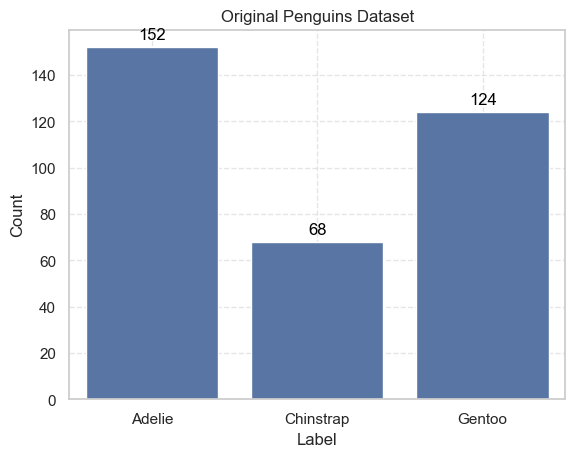

In [16]:
# Show the chart of original data
plot_original_distribution(label, "Original Penguins Dataset")

In [17]:
# set up the proportions
splits = [(0.4, 0.6), (0.6, 0.4), (0.8, 0.2), (0.9, 0.1)]
# Implement preparing data 
datasets, feature_names = prepare_splits(feature, label, splits)

C:\Users\ACER\AppData\Local\Temp\ipykernel_12908\539650868.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(short_labels, rotation=0)
C:\Users\ACER\AppData\Local\Temp\ipykernel_12908\539650868.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(short_labels, rotation=0)


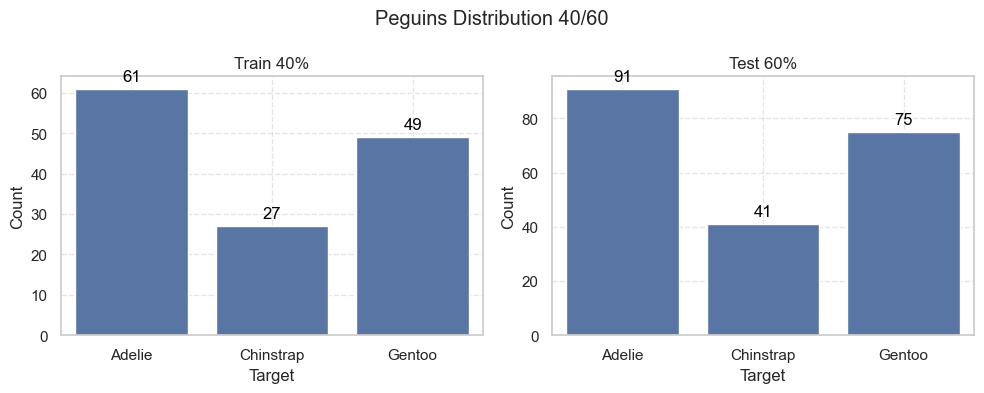

C:\Users\ACER\AppData\Local\Temp\ipykernel_12908\539650868.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(short_labels, rotation=0)
C:\Users\ACER\AppData\Local\Temp\ipykernel_12908\539650868.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(short_labels, rotation=0)


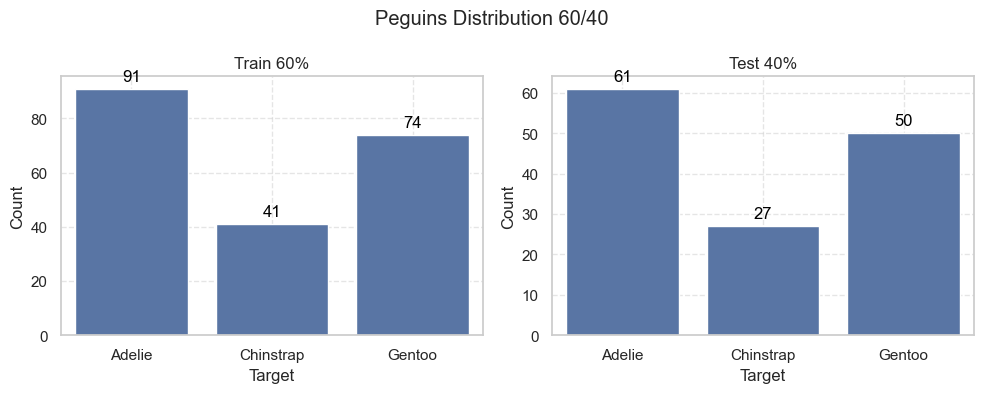

C:\Users\ACER\AppData\Local\Temp\ipykernel_12908\539650868.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(short_labels, rotation=0)
C:\Users\ACER\AppData\Local\Temp\ipykernel_12908\539650868.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(short_labels, rotation=0)


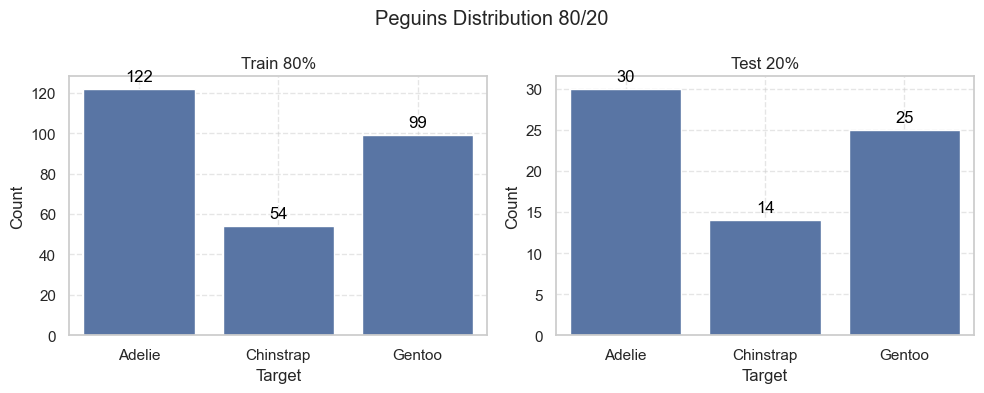

C:\Users\ACER\AppData\Local\Temp\ipykernel_12908\539650868.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(short_labels, rotation=0)
C:\Users\ACER\AppData\Local\Temp\ipykernel_12908\539650868.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(short_labels, rotation=0)


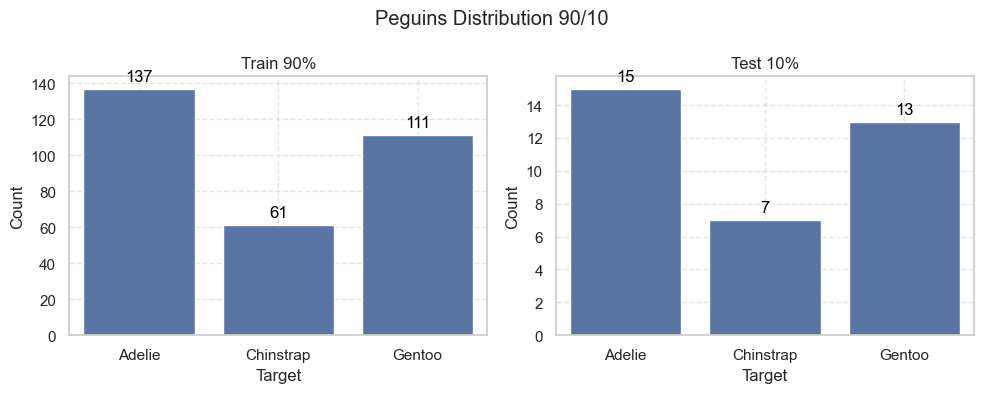

In [18]:
# show charts of datasets after we "preparing" 
plot_class_distributions(datasets, splits, "Study Name")


In [ ]:
print(datasets)

[(     studyName  Sample Number  Region  Island  Stage  Individual ID  \
317          1             74       0       2      0             57   
127          2             46       0       1      0            163   
34           1             90       0       1      0             77   
188          1             28       0       1      0            109   
69           2            137       0       1      0            144   
..         ...            ...     ...     ...    ...            ...   
329          2            110       0       0      0             99   
154          1             85       0       1      0             70   
25           0             25       0       0      0              8   
174          0             41       0       1      0             36   
187          1             88       0       1      0             73   

     Clutch Completion  Date Egg  Culmen Length (mm)  Culmen Depth (mm)  \
317                  1         4                45.8               18.

🌲 Tree 1


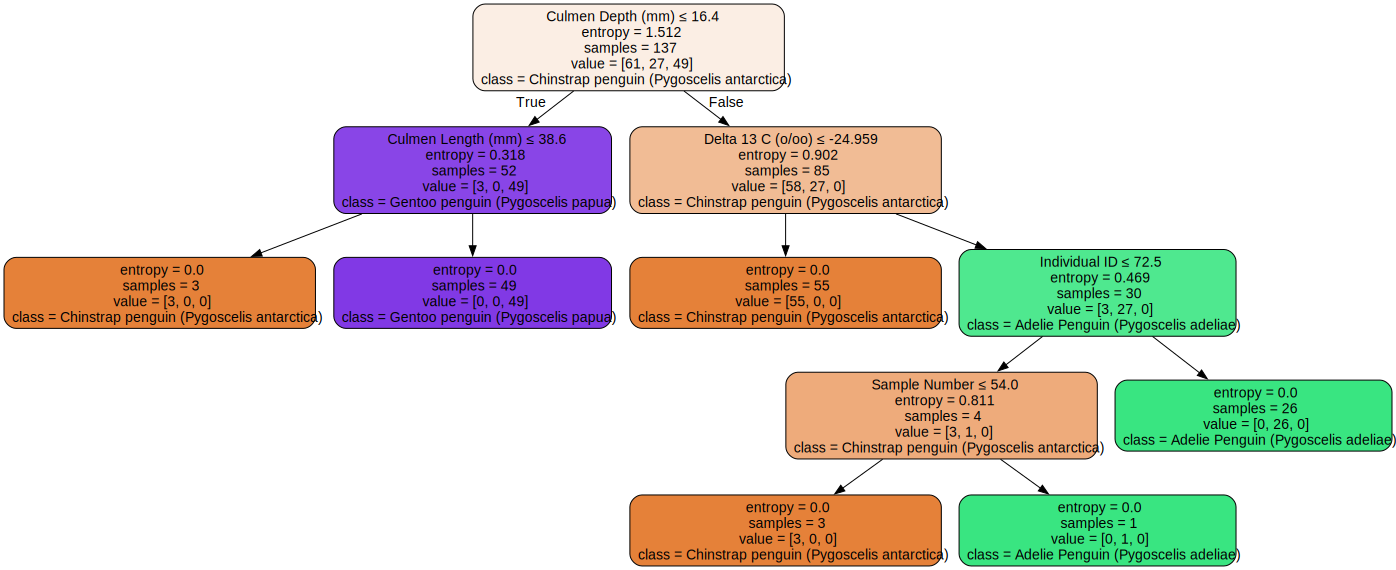

🌲 Tree 2


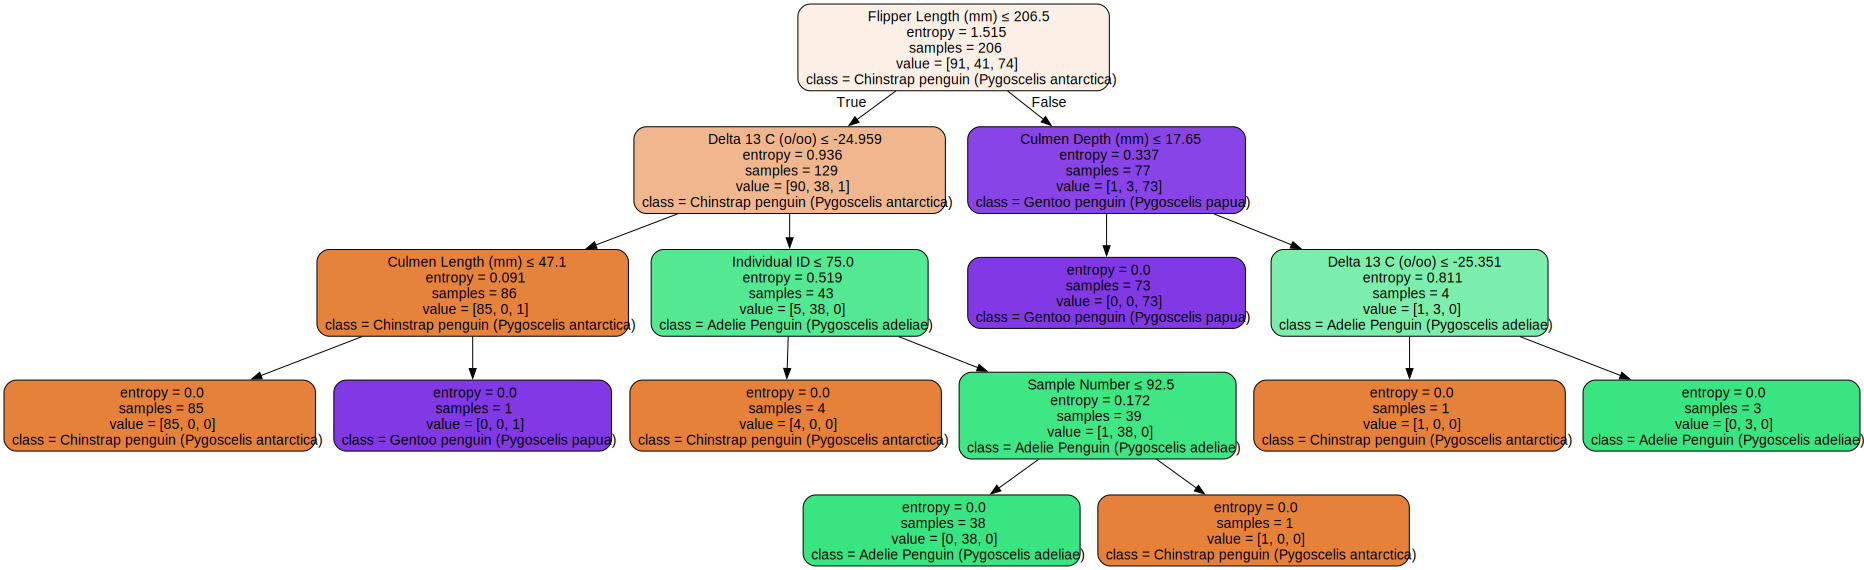

🌲 Tree 3


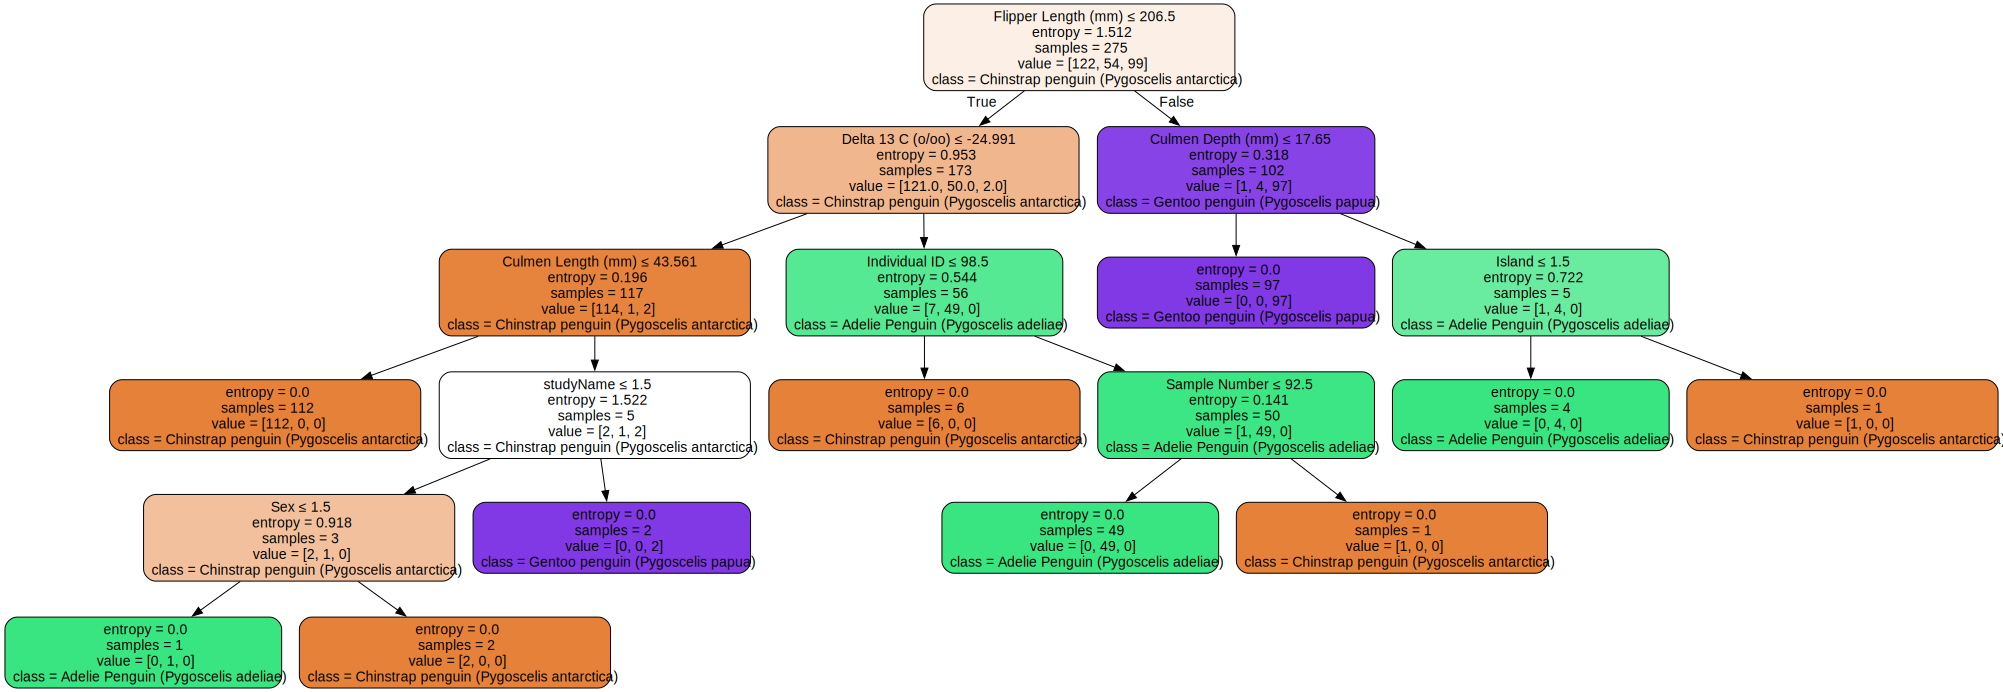

🌲 Tree 4


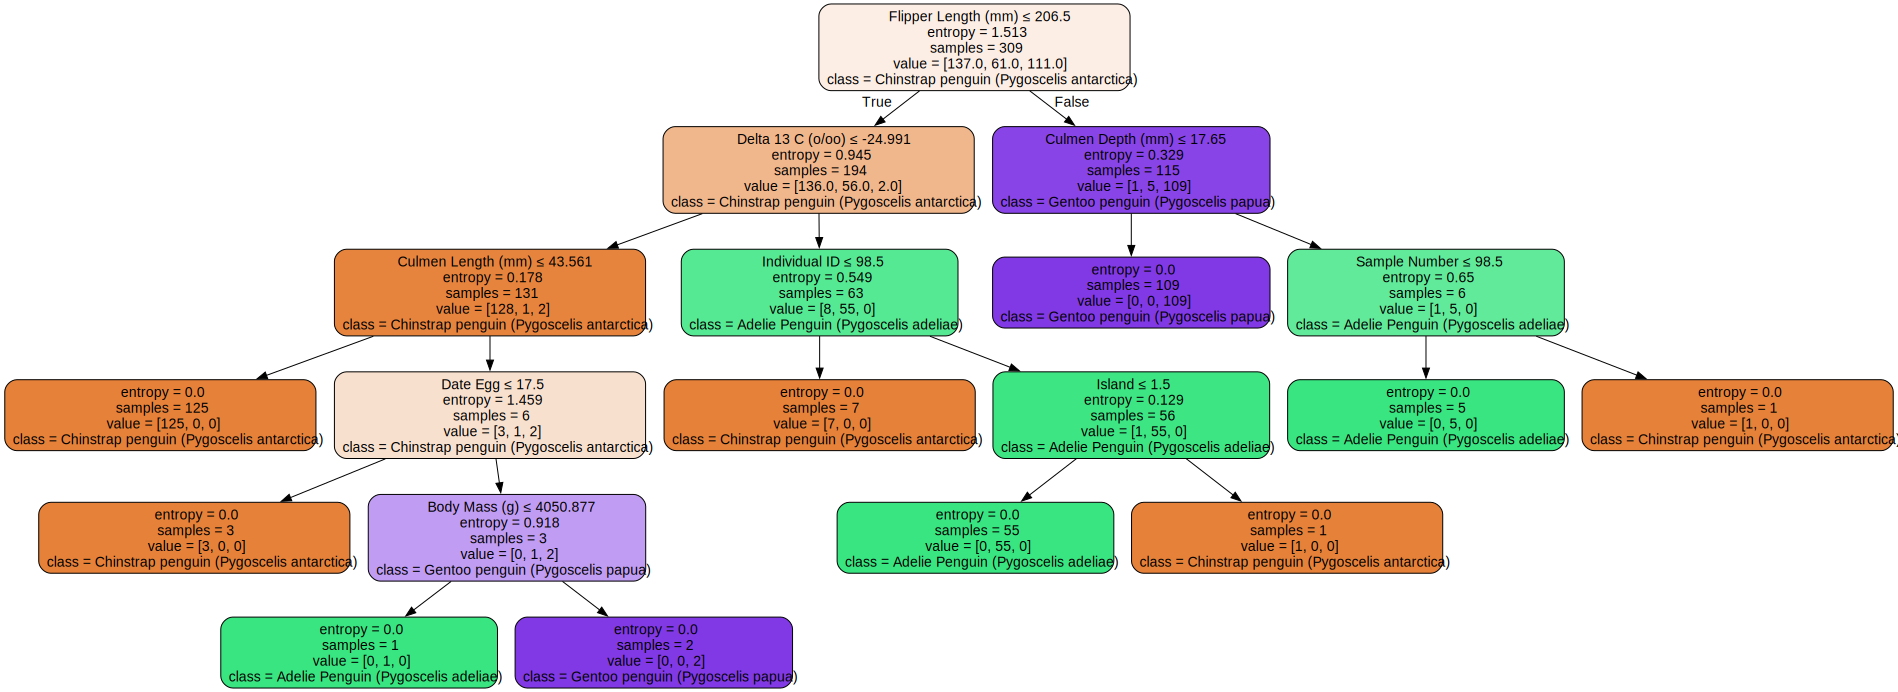

In [ ]:
# train data
clfs = train_all_models(datasets)
# visualize the trees based on trained models of datasets (clfs)
visualize_all(clfs, feature_names=X.columns.tolist(), class_names=["Chinstrap penguin (Pygoscelis antarctica)", 
                                                                   "Adelie Penguin (Pygoscelis adeliae)",
                                                                   "Gentoo penguin (Pygoscelis papua)"])

📊 Evaluation Tree 1: (39.8% train)
                   precision    recall  f1-score   support

   Adelie Penguin       0.88      0.98      0.93        91
Chinstrap penguin       0.95      0.90      0.93        41
   Gentoo penguin       0.99      0.88      0.93        75

         accuracy                           0.93       207
        macro avg       0.94      0.92      0.93       207
     weighted avg       0.93      0.93      0.93       207



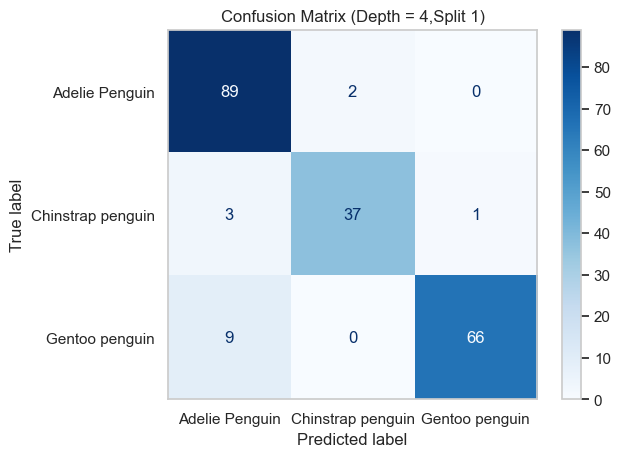

📊 Evaluation Tree 2: (59.9% train)
                   precision    recall  f1-score   support

   Adelie Penguin       0.95      0.98      0.97        61
Chinstrap penguin       0.96      0.85      0.90        27
   Gentoo penguin       0.96      0.98      0.97        50

         accuracy                           0.96       138
        macro avg       0.96      0.94      0.95       138
     weighted avg       0.96      0.96      0.96       138



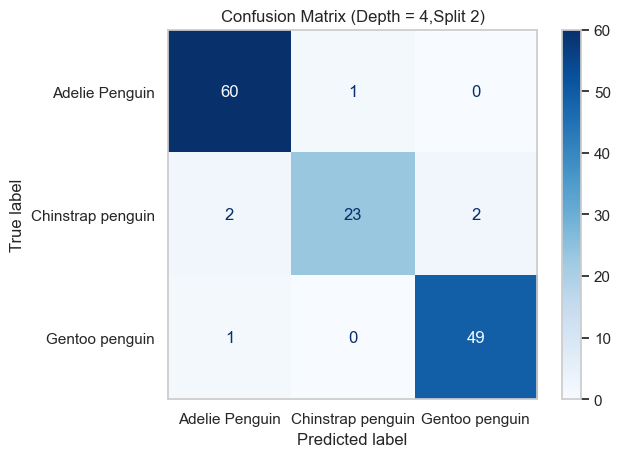

📊 Evaluation Tree 3: (79.9% train)
                   precision    recall  f1-score   support

   Adelie Penguin       0.93      0.93      0.93        30
Chinstrap penguin       0.92      0.86      0.89        14
   Gentoo penguin       0.96      1.00      0.98        25

         accuracy                           0.94        69
        macro avg       0.94      0.93      0.93        69
     weighted avg       0.94      0.94      0.94        69



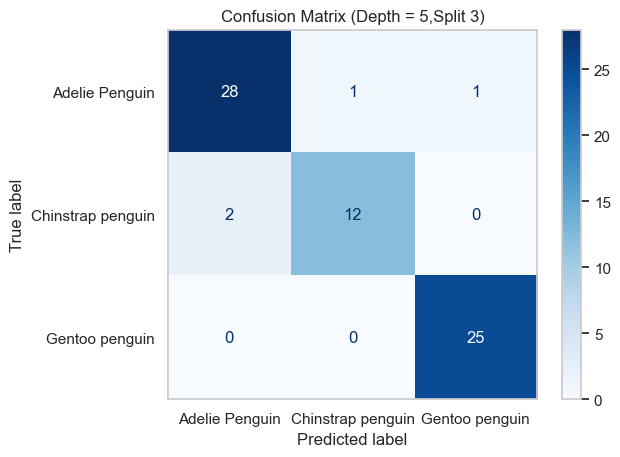

📊 Evaluation Tree 4: (89.8% train)
                   precision    recall  f1-score   support

   Adelie Penguin       0.88      0.93      0.90        15
Chinstrap penguin       0.83      0.71      0.77         7
   Gentoo penguin       1.00      1.00      1.00        13

         accuracy                           0.91        35
        macro avg       0.90      0.88      0.89        35
     weighted avg       0.91      0.91      0.91        35



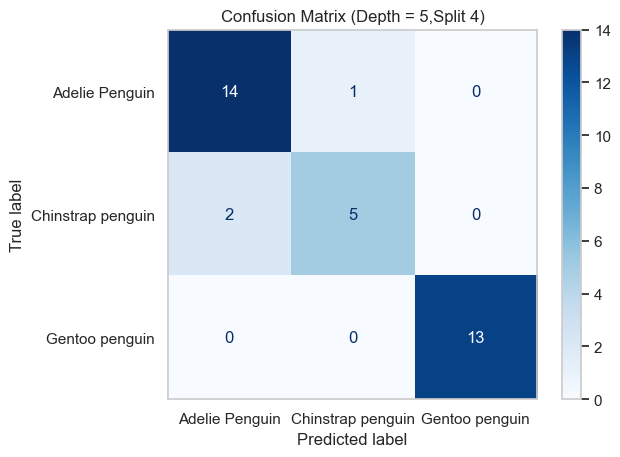

In [ ]:
evaluate_all(clfs, datasets, class_names=["Chinstrap penguin (Pygoscelis antarctica)", 
                                                                   "Adelie Penguin (Pygoscelis adeliae)",
                                                                   "Gentoo penguin (Pygoscelis papua)"])


🌲 Decision Tree with max_depth = None, Accuracy = 0.9420


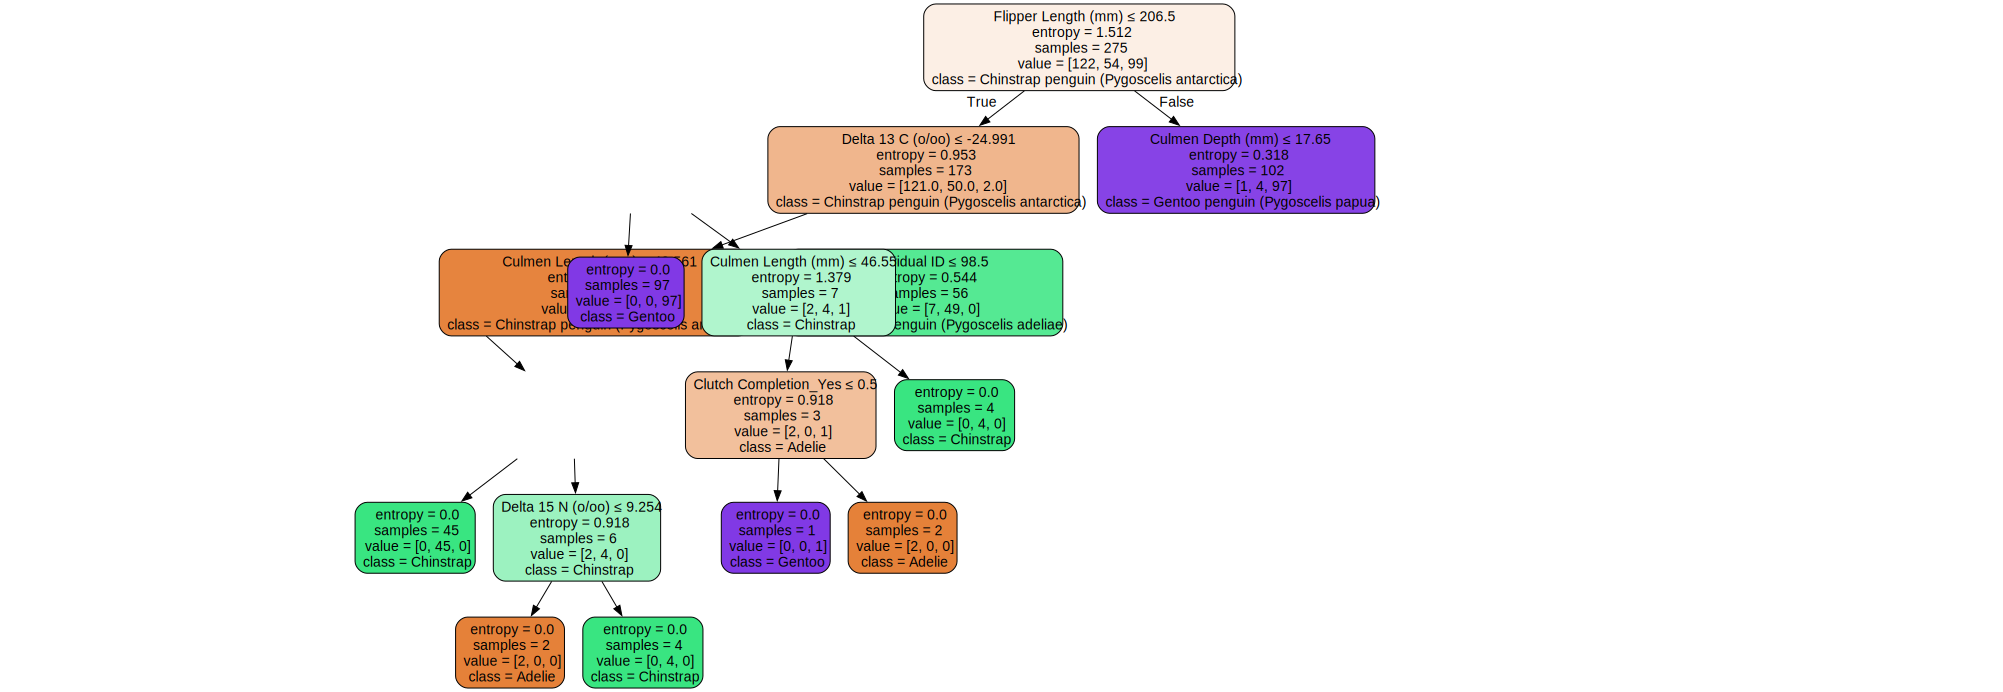

Decision Tree with max_depth = 2, Accuracy = 0.9565


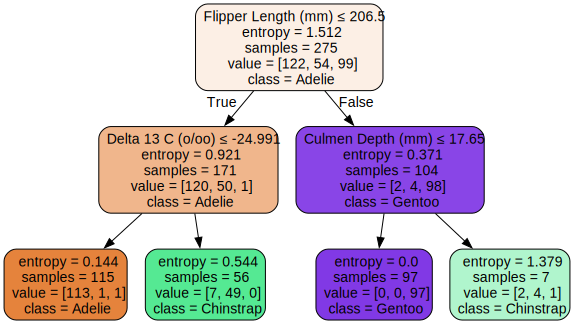

Decision Tree with max_depth = 3, Accuracy = 0.9855


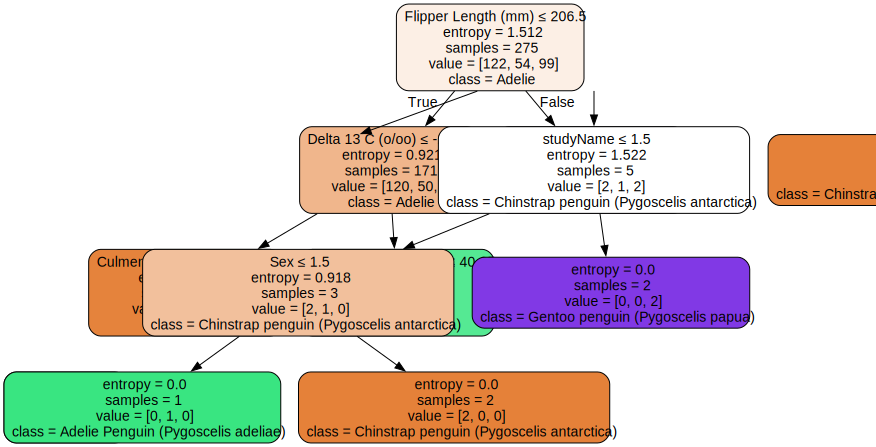

🌲 Decision Tree with max_depth = 2, Accuracy = 0.9565


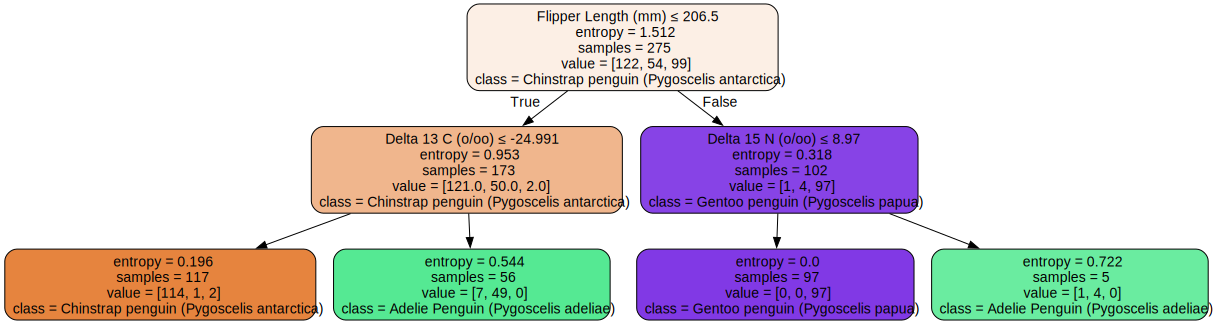

🌲 Decision Tree with max_depth = 3, Accuracy = 0.9565


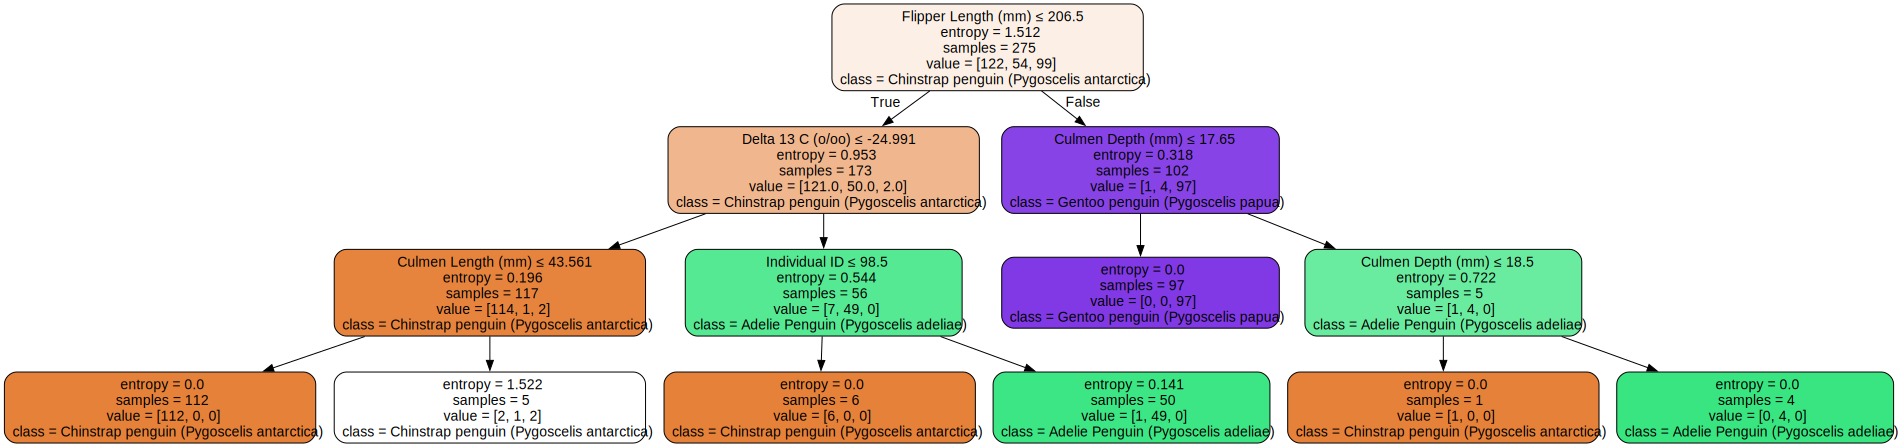

🌲 Decision Tree with max_depth = 4, Accuracy = 0.9565


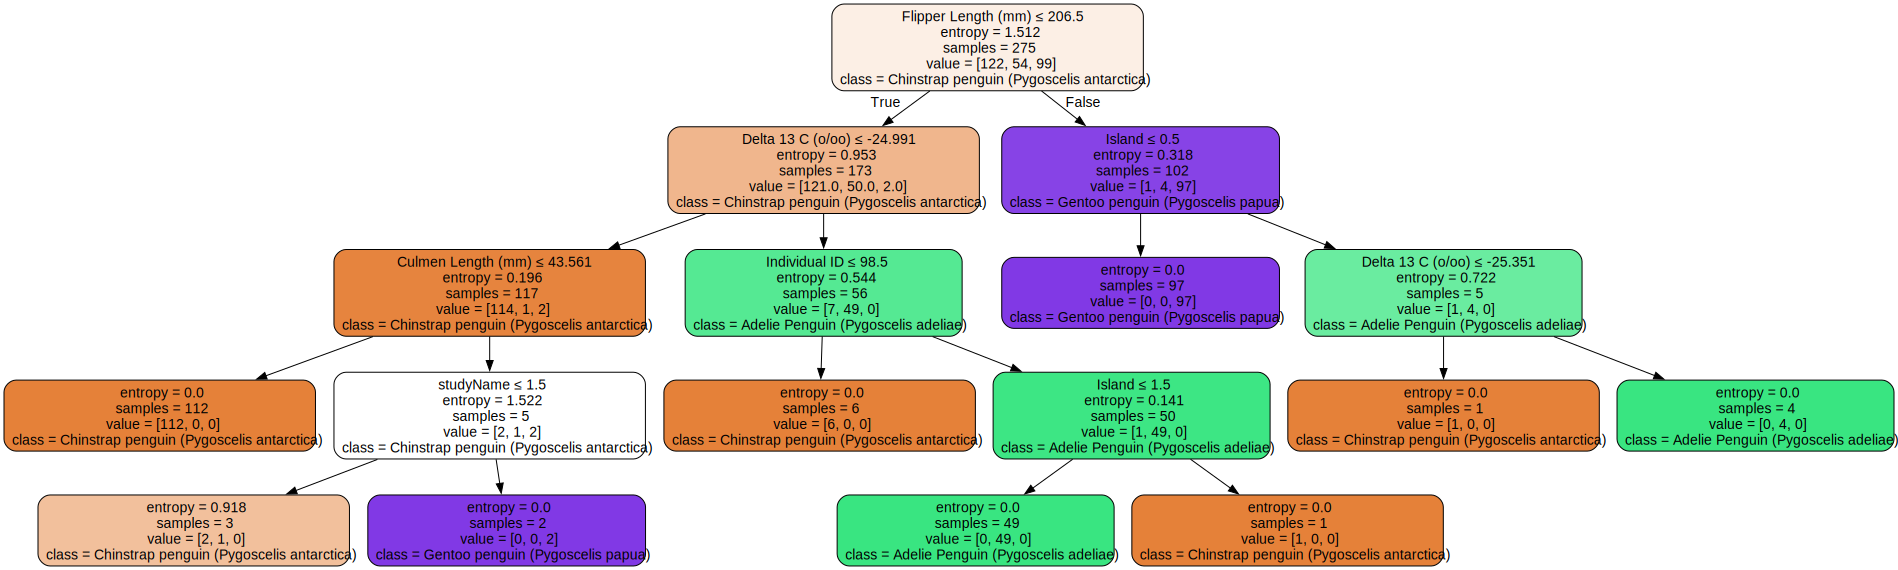

🌲 Decision Tree with max_depth = 5, Accuracy = 0.9420


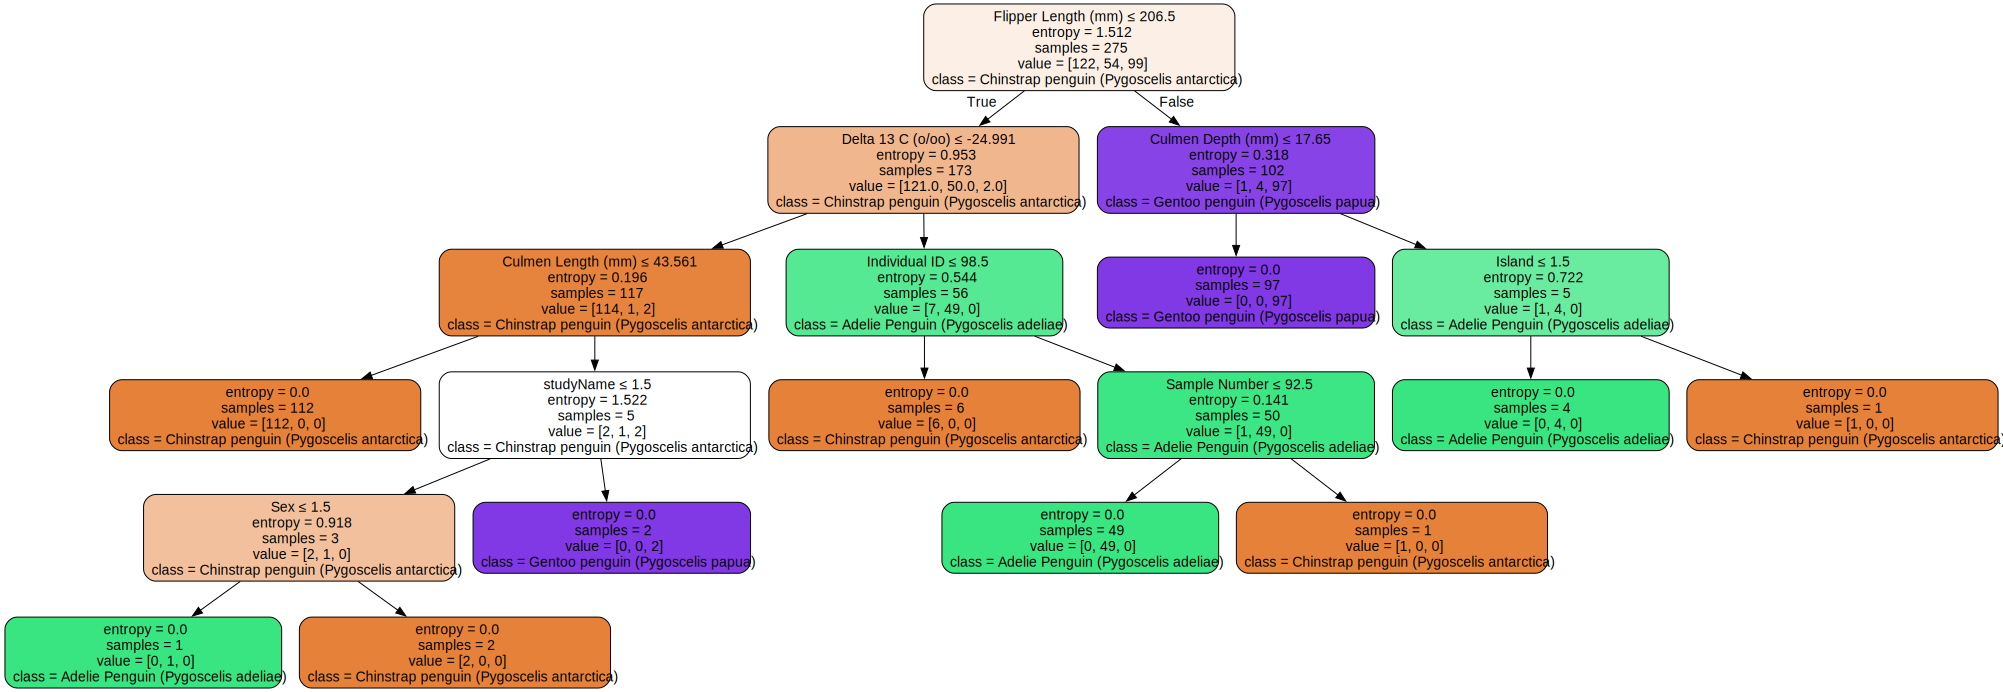

🌲 Decision Tree with max_depth = 6, Accuracy = 0.9420


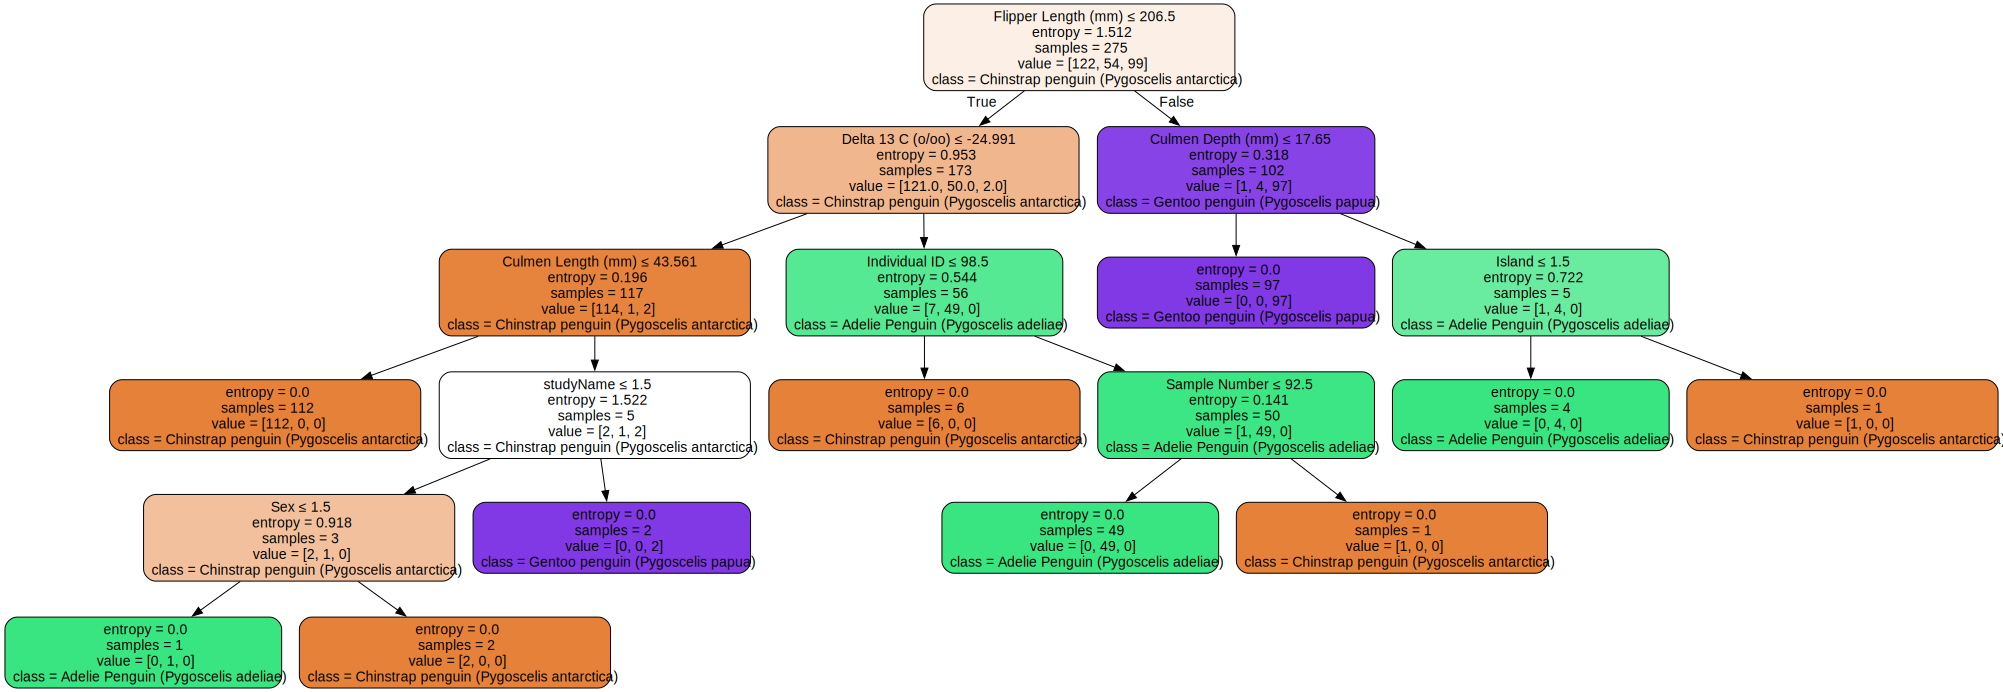

🌲 Decision Tree with max_depth = 7, Accuracy = 0.9420


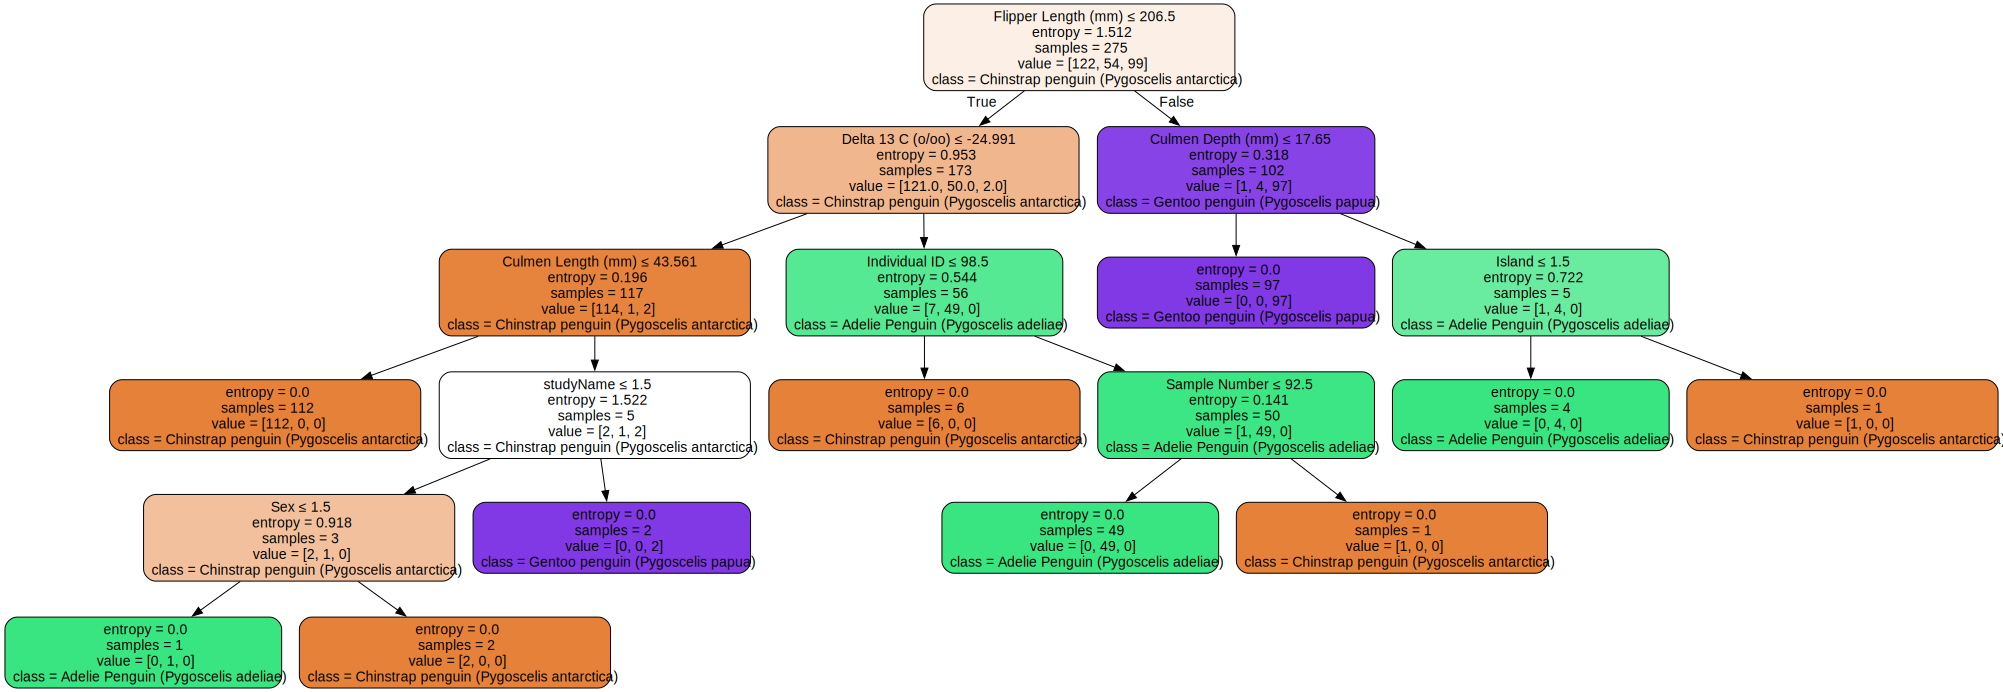

  max_depth  accuracy
0      None  0.942029
1         2  0.956522
2         3  0.956522
3         4  0.956522
4         5  0.942029
5         6  0.942029
6         7  0.942029


In [ ]:
X_train, X_test, y_train, y_test = datasets[2]  # 80/20 split

results_df = analyze_accuracy_vs_depth(
    dataset=(X_train, X_test, y_train, y_test),
    feature_names=X.columns.tolist(),
    class_names=["Chinstrap penguin (Pygoscelis antarctica)", 
                 "Adelie Penguin (Pygoscelis adeliae)",
                    "Gentoo penguin (Pygoscelis papua)"]
    
)

print(results_df)

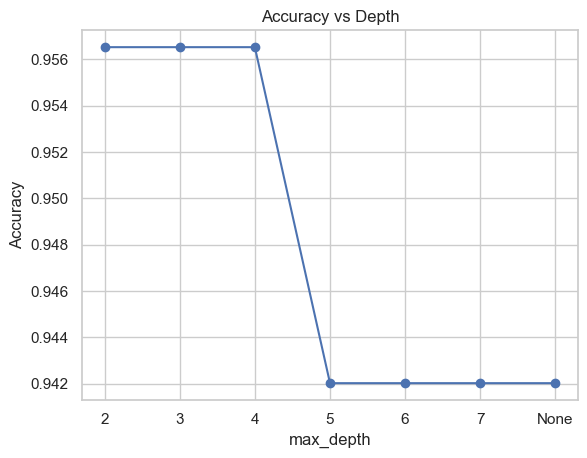

In [ ]:
# line chart between Accuracy and Depth
plot_accuracy_vs_depth(results_df, title="Accuracy vs Depth")